## IDs:
ID 1: 204502926 <br>
ID 2: 000000000

## Imports:

In [1]:
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from numpy.linalg import solve

np.random.seed(0)

### Question 1: Data exploration (15 points)

#### Answer:

In [2]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False): 
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=5, bbox={'facecolor':'k', 'pad':5},color='w')
    ax.set_xlabel(xlab, fontsize=16, labelpad=10)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    plt.xticks(rotation=45)
    plt.hist(dataset[attribute], bins=50, color=bar_color, ec=edge_color, linewidth=2)

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
Sparsity: 0.9369533063577546



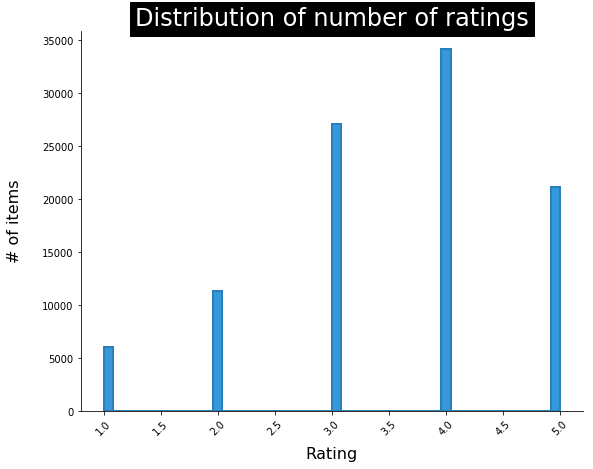

In [3]:
# Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item. 
# Include additional exploration you find relevant to questions 2 and 3.
# Discuss your insights and possible challenges related to the prediction task described in question 2.


# Remember that sparsity is calculated by the number of cells in a matrix that contain a rating divided by the total number of values that matrix could hold given the number of users and items (movies). 
# In other words, dividing the number of ratings present in the matrix by the product of users and movies in the matrix and subtracting that from 1 will give us the sparsity or the percentage of the ratings matrix that is empty.

file_path = 'ml-100k/u.data' # grouplens.org/datasets/movielens/100k

names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(file_path, sep='\t', names=names)

print(data.head())

all_users_ids = data.user_id.unique()
all_items_ids = data.item_id.unique()
ratings_count = data.shape[0] # 100,000
users_count = len(all_users_ids)
items_count = len(all_items_ids)
sparsity = 1 - (ratings_count / (users_count * items_count))
print(f'Sparsity: {sparsity}')
print()


make_histogram(data, 'rating', title='Distribution of number of ratings', xlab='Rating', ylab='# of items')

We can see that **'4'** is the dominant rating (34,174 ratings)<br>
The average rating is: $\frac{\sum_{i=1}^n(i * y(i))}{|S|}$, where i is a rating value (1-5), y(i) is the amount of ratings per user/item, and |S| is the size of the dataset (100K).<br>
We can also see that the users are more prone to give a perfect rating ('5') rather than < '3'.

In [4]:
average = sum(data['rating']) / len(data['rating'])
print(f'The average rating is {average}')

The average rating is 3.52986



### Question 2: Matrix factorization model implementation and evaluation (60 points)

#### Answer:

In [5]:
def create_rating_matrix_from_raw_data(df):
    ratings = np.zeros((all_users_ids.shape[0], all_items_ids.shape[0]))

    for row in df.itertuples():
        ratings[row[1]-1][row[2]-1] = row[3]  
        
    return ratings

In [6]:
ratings = create_rating_matrix_from_raw_data(data)
# ratings.shape

In [7]:
def get_5_folds(folds_dir='./ml-100k/'):
    number_of_folds = 5
    header = ['user_id', 'item_id', 'rating', 'timestamp']
    folds = []
    
    for i in range(number_of_folds):     
        print(f'{folds_dir}u{i+1}.base')
        
        df_train = pd.read_csv(f'{folds_dir}u{i+1}.base', sep='\t', names=header)
        df_test = pd.read_csv(f'{folds_dir}u{i+1}.test', sep='\t', names=header)   
        
        rating_train = create_rating_matrix_from_raw_data(df_train)
        rating_test  = create_rating_matrix_from_raw_data(df_test)        
           
        folds.append((rating_train, rating_test))
        
    return folds


folds = get_5_folds()

for fold in folds:
    print(fold[0].shape, fold[1].shape)

./ml-100k/u1.base
./ml-100k/u2.base
./ml-100k/u3.base
./ml-100k/u4.base
./ml-100k/u5.base
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)


In [8]:
training_data, test_data = folds[0]
training_data.shape

(943, 1682)

In [9]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    
    return mean_squared_error(pred, actual)

In [10]:
class ExplicitMFSGD():
    def __init__(self, 
                 ratings,
                 k_factors = 40,
                 item_fact_reg = 0.0, 
                 user_fact_reg = 0.0,
                 item_bias_reg = 0.0,
                 user_bias_reg = 0.0,
                 verbose = False):
        """
        Train a matrix factorization model to predict empty entries in a matrix. 
        The terminology assumes a ratings matrix which is ~ user x item.
        
        Params
        ======
        ratings: (ndarray)
            User x Item matrix with corresponding ratings
        
        k_factors: (int)
            Number of latent factors to use in matrix factorization model
        
        item_fact_reg: (float)
            Regularization term for item latent factors
        
        user_fact_reg: (float)
            Regularization term for user latent factors
            
        item_bias_reg: (float)
            Regularization term for item biases
        
        user_bias_reg: (float)
            Regularization term for user biases
        
        verbose: (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.users_count = users_count
        self.items_count = items_count
        self.k_factors = k_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg

        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        
        self._v = verbose

    
    def train(self, n_iter=10, learning_rate=0.1):
        """
        Train model for n_iter iterations from scratch
        """
        
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.k_factors, size=(self.users_count, self.k_factors))
        self.item_vecs = np.random.normal(scale=1./self.k_factors, size=(self.items_count, self.k_factors))
        
        self.learning_rate = learning_rate
        self.user_bias = np.zeros(self.users_count)
        self.item_bias = np.zeros(self.items_count)
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. 
        Can be called multiple times for further training.
        """
        ctr = 1
                
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print(f'\tStill running...')
                print(f'\tCurrent iteration: {ctr}')
                
            self.training_indices = np.arange(self.n_samples)
            np.random.shuffle(self.training_indices)
            self.sgd()
            
            ctr += 1


    def sgd(self):
        for idx in self.training_indices:
            user = self.sample_row[idx]
            item = self.sample_col[idx]
            prediction = self.predict(user, item)
            actual_rating = self.ratings[user, item] # get actual rating from the dataset's ratings array 
            error = actual_rating - prediction
            
            # Update biases
            self.user_bias[user] += self.learning_rate * (error - self.user_bias_reg * self.user_bias[user])
            self.item_bias[item] += self.learning_rate * (error - self.item_bias_reg * self.item_bias[item])
            
            #Update latent factors
            self.user_vecs[user, :] += self.learning_rate * (error * self.item_vecs[item, :] - self.user_fact_reg * self.user_vecs[user,:])
            self.item_vecs[item, :] += self.learning_rate * (error * self.user_vecs[user, :] - self.item_fact_reg * self.item_vecs[item,:])
    
    
    def predict(self, user, item):
        """
        Single user and item prediction
        """
        biases = self.global_bias + self.user_bias[user] + self.item_bias[item]
        prediction_value = biases + self.user_vecs[user, :].dot(self.item_vecs[item, :].T)
        
        return prediction_value
    
    
    def get_prediction_matrix(self):
        """
        Predict ratings for every user and item
        """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        
        for user in range(self.user_vecs.shape[0]):
            for item in range(self.item_vecs.shape[0]):
                predictions[user, item] = self.predict(user, item)
                
        return predictions
    
    
    def calculate_learning_curve(self, iter_array, test, learning_rate):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array: (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        
        test: (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        
        !!! The function creates two new class attributes:
        
        training_mse: (list)
            Training data MSE values for each value of iter_array
        
        test_mse: (list)
            Test data MSE values for each value of iter_array
        """
        
        iter_array.sort()
        self.training_mse = []
        self.test_mse = []
        iter_diff = 0
        
        for (i, n_iter) in enumerate(iter_array):            
            if self._v:
                print(f'k = {self.k_factors}, alpha = {learning_rate}, iterations = {n_iter}')
                
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.get_prediction_matrix()

            self.training_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            
            if self._v:
                training_MSE = self.training_mse[-1] # -1 for last index (final error value is when the final iteration finished)
                test_MSE = self.test_mse[-1]
                print(f'Training MSE = {training_MSE}')
                print(f'Test MSE = {test_MSE}')
                
            iter_diff = n_iter
            
        print('======================')
        return training_MSE, test_MSE

In [11]:
# sns.set()

# def plot_learning_curve(iter_array, model, k, learning_rate):
#     plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

#     plt.plot(iter_array, model.training_mse, label=f"Training k={{{0}}}, alpha={{{1}}}".format(k, learning_rate), linewidth=5)
#     plt.plot(iter_array, model.test_mse, label=f"Test k={{{0}}}, alpha={{{1}}}".format(k, learning_rate), linewidth=5)

#     plt.xticks(fontsize=16);
#     plt.yticks(fontsize=16);
#     plt.xlabel('iterations', fontsize=30);
#     plt.ylabel('MSE', fontsize=30);
#     plt.legend(loc='best', fontsize=20);

In [20]:
sns.set()

def plot_learning_curve_list(iter_array, models, title, mse_extractor):
    plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

    for i in models:
        model, k, learning_rate = i
        print(k)
        print(learning_rate)
        plt.plot(iter_array, mse_extractor(model), label=f"{title} k={k}, alpha={learning_rate}", linewidth=5)

    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
#     plt.title(title)
    plt.legend(loc='best', fontsize=20);

In [13]:
# k_options = [10, 40]
# learning_rate_options = [0.001, 0.01]
# iter_array = [1, 2, 5, 10]

k_options = [20, 30, 40, 70, 150]
learning_rate_optiAons = [0.001, 0.01, 0.1]
iter_array = [1, 5, 10, 25, 50, 100, 200]

MF_SGD_list = []

for k in k_options:
    for learning_rate in learning_rate_options:
#         for item_fact_reg
#         for user_fact_reg
#         for bias ???
        MFSGD = ExplicitMFSGD(training_data, k, verbose=True)
        training_MSE, test_MSE = MFSGD.calculate_learning_curve(iter_array, test_data, learning_rate)
        MF_SGD_list.append([MFSGD, k, learning_rate])

k = 10, alpha = 0.001, iterations = 1
Training MSE = 1.1468347949236344
Test MSE = 1.2277400715277342
k = 10, alpha = 0.001, iterations = 2
Training MSE = 1.082338408659529
Test MSE = 1.1616775842942786
k = 10, alpha = 0.001, iterations = 5
Training MSE = 0.9847574450317538
Test MSE = 1.0604823652952085
k = 10, alpha = 0.001, iterations = 10
Training MSE = 0.9215602102985806
Test MSE = 0.9978925324825042
k = 10, alpha = 0.01, iterations = 1
Training MSE = 0.9227964208283546
Test MSE = 0.9986129307118689
k = 10, alpha = 0.01, iterations = 2
Training MSE = 0.8754515257819483
Test MSE = 0.9565051811628986
k = 10, alpha = 0.01, iterations = 5
Training MSE = 0.8260786780053968
Test MSE = 0.9278387498818651
k = 10, alpha = 0.01, iterations = 10
Training MSE = 0.7403764100233857
Test MSE = 0.9163381266737303
k = 40, alpha = 0.001, iterations = 1
Training MSE = 1.1462929551394914
Test MSE = 1.2265517485613848
k = 40, alpha = 0.001, iterations = 2
Training MSE = 1.0821402368728685
Test MSE = 1.

10
0.001
10
0.01
40
0.001
40
0.01
10
0.001
10
0.01
40
0.001
40
0.01


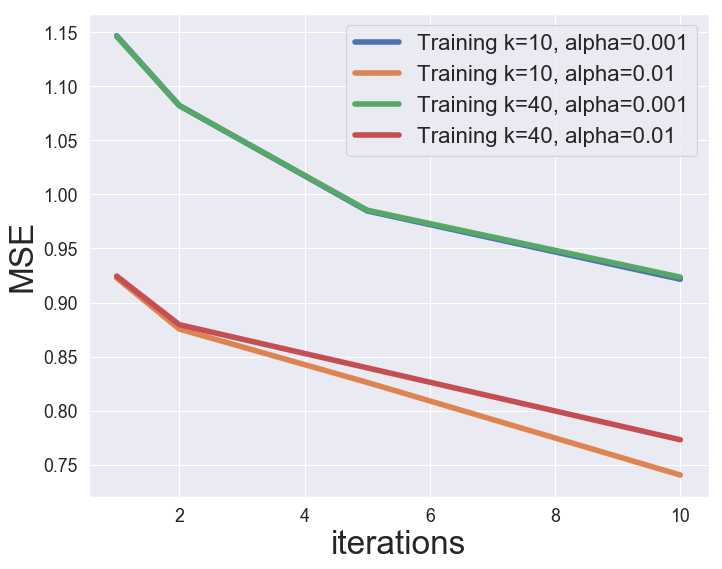

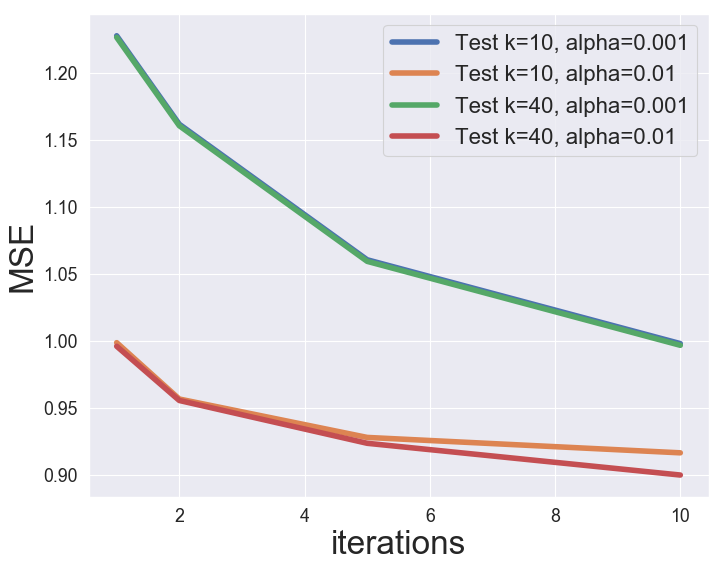

In [21]:
plot_learning_curve_list(iter_array, MF_SGD_list, title='Training', mse_extractor=lambda model: model.training_mse)
plot_learning_curve_list(iter_array, MF_SGD_list, title='Test', mse_extractor=lambda model: model.test_mse)

10
0.001


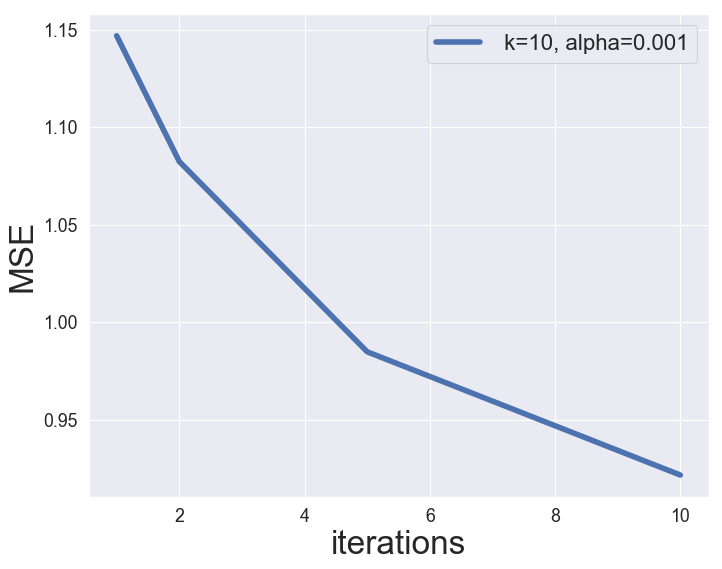

In [22]:
sns.set()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

model, k, learning_rate = MF_SGD_list[0]
print(k)
print(learning_rate)
plt.plot(iter_array, model.training_mse, label=f" k={k}, alpha={learning_rate}", linewidth=5)

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('iterations', fontsize=30);
plt.ylabel('MSE', fontsize=30);
#   plt.title(title)
plt.legend(loc='best', fontsize=20);

10
0.01


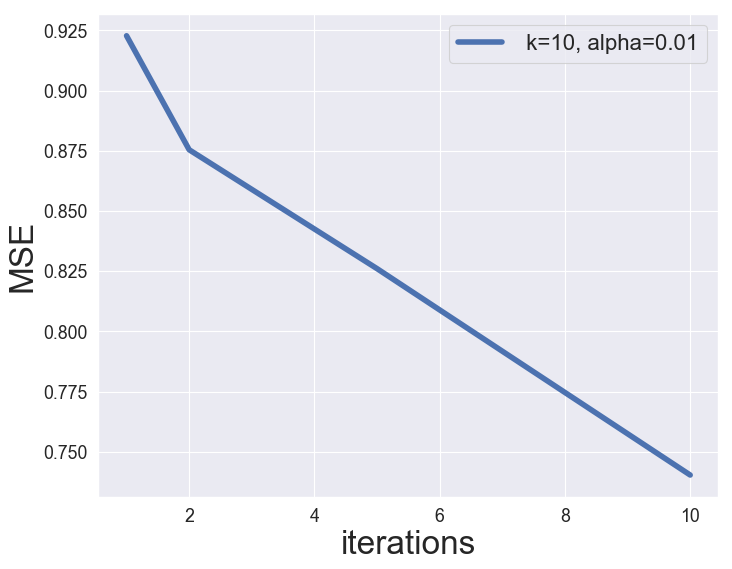

In [23]:
sns.set()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

model, k, learning_rate = MF_SGD_list[1]
print(k)
print(learning_rate)
plt.plot(iter_array, model.training_mse, label=f" k={k}, alpha={learning_rate}", linewidth=5)

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('iterations', fontsize=30);
plt.ylabel('MSE', fontsize=30);
#   plt.title(title)
plt.legend(loc='best', fontsize=20);

40
0.001


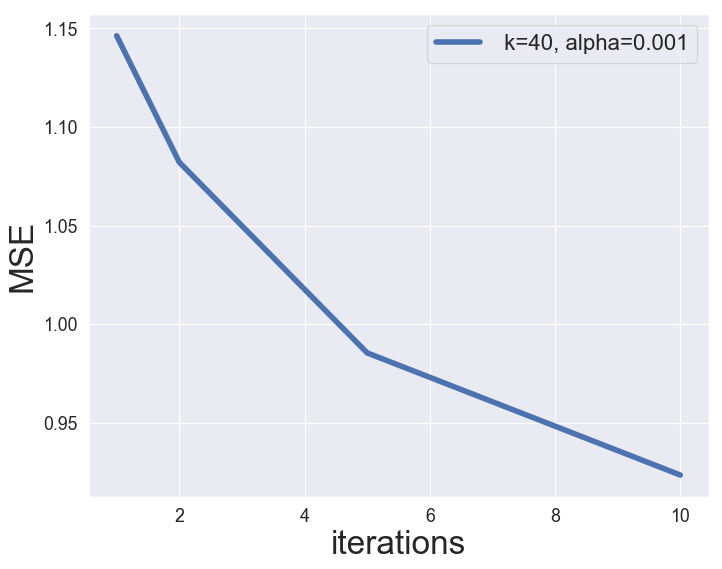

In [24]:
sns.set()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

model, k, learning_rate = MF_SGD_list[2]
print(k)
print(learning_rate)
plt.plot(iter_array, model.training_mse, label=f" k={k}, alpha={learning_rate}", linewidth=5)

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('iterations', fontsize=30);
plt.ylabel('MSE', fontsize=30);
#   plt.title(title)
plt.legend(loc='best', fontsize=20);

40
0.01


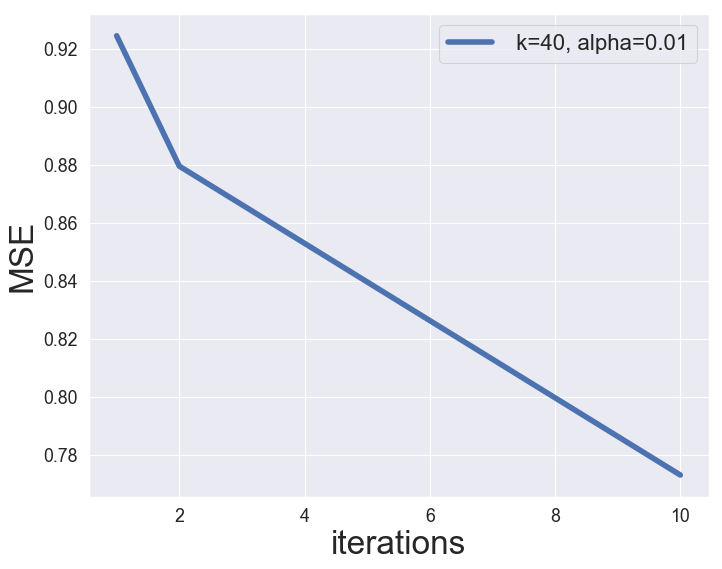

In [25]:
sns.set()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

model, k, learning_rate = MF_SGD_list[3]
print(k)
print(learning_rate)
plt.plot(iter_array, model.training_mse, label=f" k={k}, alpha={learning_rate}", linewidth=5)

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('iterations', fontsize=30);
plt.ylabel('MSE', fontsize=30);
#   plt.title(title)
plt.legend(loc='best', fontsize=20);

### Question 3: Matrix factorization – item similarity and model explainability (25 points)

#### Answer: